In [1]:
# Importing required packages 
from qiskit import IBMQ, QuantumCircuit, Aer, execute, ClassicalRegister
from qiskit.quantum_info import Operator, Statevector, state_fidelity
from qiskit.visualization import plot_state_qsphere, plot_histogram, plot_state_city
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua.algorithms import VQE
import numpy as np
import random, math
from scipy import optimize as opt
import matplotlib.pyplot as plt
from IPython.display import Image
import mitiq

provider = IBMQ.load_account()


C:\Users\javie\anaconda3\envs\qiskit_env\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# Introduction 

Quantum computers provide a natural platform to perform simulations for the evolution of systems
Proposals of simulations of quantum field theories and experimental implementation (Zoller etc.) 
Klco et al. reducing the physical space and studying the discretized Schwinger model, proposal to study the noise restrictions they faced with the help of the mitiq package

## VQE of the ground state energy 

Through the use of physical symmetries within the system it is possible to restrict the matrix to the form 

\begin{equation}
H_{k=0,+}^{\lambda^2 = 3} =
\begin{pmatrix}
-2\mu & 2x & 0 & 0\\
2x & 1 & \sqrt{2}x & 0\\
0 & \sqrt{2}x & 2 + 2\mu & \sqrt{2}x \\
0 & 0 & \sqrt{2}x & 3 
\end{pmatrix}
\end{equation}

This 4x4 matrix can then be expressed in term of the polywords. 

\begin{equation}
\cal{O}_{i,j} = \frac{1}{4}\sigma_{i} \otimes \sigma_{j} 
\end{equation}
with $i,j = 0,1,2,3$ representing the Pauli matrices. Such that the hamiltonian is written as
\begin{equation}
H = \sum_{i,j} c_{i,j}\cal{O}_{i,j}
\end{equation} 
with each coefficient calculated as inner product of the matrices with the Hamiltonian (equivalent to finding the coefficients of real vector through the application of dot products) 

\begin{equation}
c_{i,j} = Tr( \cal{O}^{\dagger}H) = Tr( \cal{O}H) 
\end{equation}





Supposing we already have the decomposition then we can then express the expectation value of the energy of the hamiltonian as 

\begin{equation} 
    \left< H \right>_{\theta} = \sum_{i}c_{i} \big< \psi(\vec{\theta}) \big| \cal{O}_{i} \big| \psi(\vec{\theta})\big>
\end{equation}

where the initial state $\big| \psi(\vec{\theta})\big> $ is determined to an specific anzats created by the circuit in E10  

To properly implement in qiskit we use the RX,RY and RZ defined as 
 
\begin{align*} 
RX(\theta) &= e^{-i\theta\frac{\sigma_{X}}{2}} \\ 
RY(\theta) &= e^{-i\theta\frac{\sigma_{Y}}{2}} \\
RZ(\theta) &= e^{-i\theta\frac{\sigma_{Z}}{2}} \\ 
\end{align*}

The created circuit is such that 

\begin{equation}
    \big| \psi(\vec{\theta})\big> = U( \vec{\theta} ) \big| \vec{0} \big>
\end{equation}

In order to find the expected value it is usefu to consider a general qubit of the form 

\begin{equation}
    \big| \psi \big> = p_{00}\big| 00 \big> + p_{01}\big| 01 \big> + p_{10}\big| 10 \big> + p_{11}\big| 11 \big> 
\end{equation}

and consider the result of the expetation value of this state with a $\sigma_{Z} \otimes \sigma_{Z}$

\begin{split}
   \big< \psi \big| \sigma_{Z} \otimes \sigma_{Z} \big| \psi \big> &= \big< \psi \big| \sigma_{Z} \otimes \sigma_{Z} \Big(  p_{00}\big| 00 \big> + p_{01}\big| 01 \big> + p_{10}\big| 10 \big> + p_{11}\big| 11 \big> \Big) \\
   &=  \big< \psi \big| \Big(  p_{00}\big| 00 \big> - p_{01}\big| 01 \big> - p_{10}\big| 10 \big> + p_{11}\big| 11 \big>   \Big) \\
   &=  |p_{00}|^2 + |p_{11}|^2 - \big( |p_{10}|^2 + |p_{01}|^2  \big)
\end{split}

so in order to measure the expectation value from the results of an experiment, we just need to sum the counts with the formula above. For the case when the other pauli matrices appear there only needs to be a change in the basis of the measurements as 

\begin{align*}
\sigma_{X} &= (H)^{\dagger} \sigma_{Z} H \\
\sigma_{Y} &= (HS^{\dagger})^{\dagger} \sigma_{Z} HS^{\dagger}
\end{align*}




In [2]:
def Hamiltonian(mu,x):
    """
    Calculates a numpy array with numerical values for the Hamiltonian defined above

    Parameters
    mu : Float value describing relative mass in the model
    x : Float value describing relative lattice spacing in the model 
    
    Return
    H : 4x4 numpy array with numerical values of the hamiltonian
    HT : 4x4 numpy array with traceless hamiltonian (extracting the terms proportional to the identity)                 
    """       
    
    #Defining array 
    H = np.array([[-2*mu, 2*x, 0, 0],\
                  [2*x, 1, np.sqrt(2)*x, 0],\
                  [0, np.sqrt(2)*x, 2+2*mu, np.sqrt(2)*x],\
                  [0, 0, np.sqrt(2)*x, 3]])
    
    #Eliminating terms proportional to the identity 
    HT = H - (3/2)*np.eye(4)
    
    return H,HT


#Values used in the paper minimization
[H,HT] = Hamiltonian(0.1,0.6)

#Analitical minimal values
eigenH,eigenHT = np.linalg.eig(H);
print(eigenH)

[-1.01163997  1.10260078  2.26804891  3.64099028]


To archive our task we will develop independent functions that will calculate the pauli matrix decomposition of the hamiltonian, in order to succesfully calculate the expectation value. 
Then we will utilize the circuit anzat from the paper and implement with three free parameters to optimize for.
A function that will modify such circuit to find the right measurement reference
And a function that will run the cirucit and extract the expectation values for different pauli coefficients 


In [3]:
def Decomposition_H(H):
    """
    Decomposes the previous hamiltonian into the respective pauli matrices (pauli-words) components.
    Uses inner product with the pauli matrices as defined above. 

    Parameters
    H : 4x4 hermitian numpy array 
    
    Return
    c : Dictionary with pauli words as keys and the respective coefficient. 
        eg. {'II': 0, 'IX': 0.32,...}                      
    """
    
    #Definition of the pauli matrices 
    sigma_0 = np.eye(2)
    sigma_X = np.array([[0,1],[1,0]])
    sigma_Y = np.array([[0,-1j],[1j,0]])
    sigma_Z = np.array([[1,0],[0,-1]])
    Pauli = [sigma_0,sigma_X,sigma_Y,sigma_Z]
    Pauli_name = ['I','X','Y','Z']
    
    #Creaiton of the pauli_words (tensor products of pauli matrices)
    ii = 0 
    Poly = []
    Poly_name = []
    for i in Pauli:
        jj = 0
        for j in Pauli:
            Poly.append(np.kron(i,j))
            Poly_name.append(Pauli_name[ii] + Pauli_name[jj])
            jj += 1
        ii += 1
    
    #Doing the partial trace for the coefficinets 
    c = {}
    for i in range(len(Poly)):
        c[Poly_name[i]] = np.real(np.trace(np.matmul(Poly[i],H))/4)
        
    return c



def State_Preparation(theta,r = 1):
    """
    Creates a qiskit quantum circuit with the anzat described in the paper. Doesn't include measurement operations.
    Includes option to scale the CNOT gates manually. 

    Parameters
    theta : 1x3 numpy array with the values of the R_{y} gates defined according to the paper anzats. 
    r : Scaling factor for the CNOT gates, adds 2 CNOT gates representing the Identity gate for each level
        eg. r = 2, adds two gates on the right of each CNOT gate in the circuit
    
    Return
    qc: Qiskit quantum circuit object               
    """
    #Start quantum circuit object with 2 qubits
    qc = QuantumCircuit(2)
    
    #Add gates 
    qc.ry(theta[1],0)
    qc.ry(theta[0],1)
    for i in range(2*r-1):
        qc.cnot(0,1)
    
    qc.ry(theta[0],1)
    for i in range(2*r-1):
        qc.cnot(0,1)
        
    qc.ry(theta[2],1)
    
    return qc


def Circuit_Measurement(qc,key):
    """
    Transform the measurement basis according to the description above according to which pauli-word expectation
    value will be calculated. Adds  Measurement to the circuit. 

    Parameters
    qc : Quantum circuit for which expectation value is desired to be calculated
    key : Key describing the pauli-words according to the dictionary defined in 'Decomposition'
          eg. of the form 'IX', 'ZZ', 'YX'.
    
    Return
    qc_state: Qiskit quantum circuit object ready to be executed
    """
    
    qc_state = qc.copy() #save original state of quantum circuit
    qc_state.add_register(ClassicalRegister(2)) #adding of classical registers
    
    #Add pauli gates for different expectation values
    for q in range(2): #Lopp over two qubits
        if key[q] == 'I' or key[q] == 'Z':
            pass
        elif key[q] == 'X':
            qc_state.h(q)
        elif key[q] == 'Y':
            qc_state.sdg(q)
            qc_state.h(q)
                    
    #Add measurement to the circut
    qc_state.measure([0,1], [0,1])
    
    return qc_state


def Expectation_Measurement(qc,key,shots=8192,backend = 'qasm_simulator', noise = False):
    """
    Runs the desired quantum circuit to calculate the expectation of desired polyword according to the description above.
    Allows to run either on a simulated or real machine, with the option of simulating the noise of a real machine. 

    Parameters
    qc : Quantum circuit for which expectation value is desired to be calculated, should have measurements included
    key : Key describing the pauli-words according to the dictionary defined in 'Decomposition'
          eg. of the form 'IX', 'ZZ', 'YX'.
    backend : String containing backend to be used, 'qasm_simulator' simulates withouth running on a real device. In case 
              it is desired to run on a real device include the name of the machine and set noise = False. 
    noise
    
    Return
    qc_state: Qiskit quantum circuit object ready to be executed
    """
    want to run on the machine, noise should be set to false and backend with the name of the machine selected
       
    if noise == False:
        #Run the circuit 

        job = execute(
        experiments=qc,
        #backend=provider.get_backend("machine name") to run on hardware
        backend=Aer.get_backend(backend),
        optimization_level=0, shots=shots
        )

    else:
        #Run the circuit
        #Note the order of the input tuple is coupling, basis and then noise
        backend_noise = provider.get_backend(noise)
        noise_model = NoiseModel.from_backend(backend_noise)
        coupling_map = backend_noise.configuration().coupling_map
        basis_gates = noise_model.basis_gates

        job = execute(experiments = qc, backend = Aer.get_backend(backend),
         coupling_map= coupling_map,
         basis_gates=basis_gates,
         noise_model=noise_model,
         optimization_level=0, 
         shots=shots
         )

    #Extract the results counts 
    counts_original = job.result().get_counts()
    counts = {}
    
    for key_count in counts_original.keys():
        counts[key_count.replace(" ","")] = counts_original[key_count]
    
    #Insert missing counts in case they're zero
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0 

    if key[0] == 'I':
        if key[1] == 'I':            
            # Case + + + +
            exp_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
            exp = exp_counts/shots

        else: 
            # Case + - + - 
            exp_counts = counts['00'] + counts['01'] - counts['10'] - counts['11']
            exp = exp_counts/shots
    else:
        if key[1] == 'I':
            #Case + + - -
            exp_counts = counts['00'] - counts['01'] + counts['10'] - counts['11']
            exp = exp_counts/shots

        else:
            #Case + - - +
            exp_counts = counts['00'] - counts['01'] - counts['10'] + counts['11']
            exp = exp_counts/shots

    return exp


In [4]:
#Example dictionary result
coef = Decomposition_H(H)
print(coef)

#Example circuit for state preparation 
qc = State_Preparation([7.27033532, 3.66176275, 1.85667239],r=1)
print(qc)

#Example for circuit to measure 'IX' expectation value
qc_IX = Circuit_Measurement(qc,'ZI')
print(qc_IX)

#Example of expectation value run for quantum circuit IX with parameters in qc
Expectation_IX = Expectation_Measurement(qc_IX,'ZI',noise = False )
print(Expectation_IX)

{'II': 1.5, 'IX': 1.0242640687119284, 'IY': 0.0, 'IZ': -0.49999999999999994, 'XI': 0.0, 'XX': 0.4242640687119285, 'XY': 0.0, 'XZ': 0.0, 'YI': 0.0, 'YX': 0.0, 'YY': 0.4242640687119285, 'YZ': 0.0, 'ZI': -1.1, 'ZX': 0.17573593128807144, 'ZY': 0.0, 'ZZ': -0.10000000000000009}
     ┌────────────┐                                      
q_0: ┤ RY(3.6618) ├──■──────────────────■────────────────
     ├────────────┤┌─┴─┐┌────────────┐┌─┴─┐┌────────────┐
q_1: ┤ RY(7.2703) ├┤ X ├┤ RY(7.2703) ├┤ X ├┤ RY(1.8567) ├
     └────────────┘└───┘└────────────┘└───┘└────────────┘
      ┌────────────┐                                      ┌─┐   
 q_0: ┤ RY(3.6618) ├──■──────────────────■────────────────┤M├───
      ├────────────┤┌─┴─┐┌────────────┐┌─┴─┐┌────────────┐└╥┘┌─┐
 q_1: ┤ RY(7.2703) ├┤ X ├┤ RY(7.2703) ├┤ X ├┤ RY(1.8567) ├─╫─┤M├
      └────────────┘└───┘└────────────┘└───┘└────────────┘ ║ └╥┘
c0: 2/═════════════════════════════════════════════════════╩══╩═
                                               

We are using the qasm_simulator because it mimicks the behaviour of an actual device (https://qiskit.org/documentation/tutorials/simulators/1_aer_provider.html)

Give that we want to use mitiq to find 

Now we are in a position to construct the function to construct the function that gives the result of the expectation value 

In [6]:
def Expectation_Hamiltonian(theta,H,noise = False, r = 1,shots=8192,backend = 'qasm_simulator'):

    #Find the Pauli decomposition
    c = Decomposition_H(H)
    exp_key = c.copy() #copy the dictionary 
    
    #Define the wavefunction anzats 
    qc = State_Preparation(theta,r = r)
    
    H_exp = 0 #Expectation value initiation
    
    for keys in c.keys():
        if c[keys] == 0: #If contribution is zero then skip step
            continue
        
        #Expectation value for Pauli matrices
        qc_key = Circuit_Measurement(qc,keys)
        
        #Run for expectation value
        exp_key[keys] = Expectation_Measurement(qc_key,keys,shots = shots,backend = backend,noise = noise)
        H_exp += c[keys]*exp_key[keys]
    return H_exp

#theta =[6.19169047, 0.23821273, 5.29788566]
theta = [7.27033532, 3.66176275, 1.85667239]
theta = [1.14854552, 6.03981858, 3.3317199 ]
Expectation_Hamiltonian(theta,H, noise = False,shots = 100000)
    
    


-0.7487613112575202

We can construct now an optimization using COBYLA method that was found in the application process to be the most effecient one, as well as the recommended one inn the qiskit tutorial for VQE (https://qiskit.org/textbook/ch-applications/vqe-molecules.html). We will be using the scipy optimization package 




In [7]:
def Optimize(H,noise = False, r = 1,shots=8192,backend = 'qasm_simulator'):

    theta_0 = 2*math.pi*np.random.random([3]) #Initial random values
    sol = opt.minimize(Expectation_Hamiltonian,theta_0,args=(H,noise,r,shots,backend),method='COBYLA',bounds=(0,2*math.pi), tol=1e-9)
    #results.append(sol.fun)
    
    return sol

In [9]:
sol = Optimize(H,shots = 50000)
print(sol,sol.x)

     fun: -0.9973217443927346
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 69
  status: 1
 success: True
       x: array([2.39581172, 5.94579978, 0.29905988]) [2.39581172 5.94579978 0.29905988]


## Optimizing using zero noise extrapolation
The recipe for using zero noise extrapolation is to find the optimal theta for r = 1, and then use those values to find the expectation results using unitary folding in the CNOT gates (how it was done in the paper although mitqit has no cnot folding only which is strange)
Note that it is not the ideal way to do it, because you're using the r = 1 angles which might be noisy

In [5]:
#Calculating manually the scaling with the folding of the CNOT gates


#Define the noises to be used 
noise = [False,
         'ibmq_vigo',
         'ibmq_16_melbourne',
         'ibmq_santiago',
         'ibmqx2'
         ]
r = 6 #Total scaling parameter to use

#Array with list for scaled values for each of the noises in respective order
Noise_Scaling = [] 


#Obtain a solution with the standard circuit
for n in noise: 
    Noise_extrapolation = []
    sol = Optimize(H,noise = n)
 

    #Extract values of theta and expectation value
    theta_optimal = sol.x
    Noise_extrapolation.append(sol.fun)

    # Finding expectation values for r = 3 to 5 with previous theta
    for r in range(2,r+1):
        Noise_extrapolation.append(Expectation_Hamiltonian(theta_optimal,H,noise = n, r = r))
        
    Noise_Scaling.append(Noise_extrapolation)




NameError: name 'Optimize' is not defined

In [ ]:
zne_simulation = Noise_Scaling[0]
zne_vigo = Noise_Scaling[1]
zne_melbourne = Noise_Scaling[2]
zne_santiago = Noise_Scaling[3]
zne_ibmqx2 = Noise_Scaling[4]

zne_noextrap  = (zne_simulation,zne_vigo,zne_melbourne,zne_santiago,zne_ibmqx2)



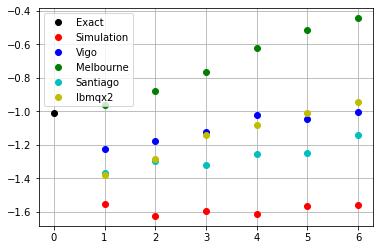

In [44]:

#Graph results without extrapolation 
labels = [1,2,3,4,5,6]

plt.figure()
plt.plot(0,eigenH[0],'ko')
plt.plot(labels,zne_simulation,'ro')
plt.plot(labels,zne_vigo,'bo')
plt.plot(labels,zne_melbourne,'go')
plt.plot(labels,zne_santiago,'co')
plt.plot(labels,zne_ibmqx2,'yo')
plt.gca().legend(('Exact','Simulation','Vigo','Melbourne','Santiago','Ibmqx2'))

_ =plt.savefig('zne without extrapolation.png')
plt.grid()

np.savetxt("zne_noextrap.csv",zne_noextrap, delimiter=",")

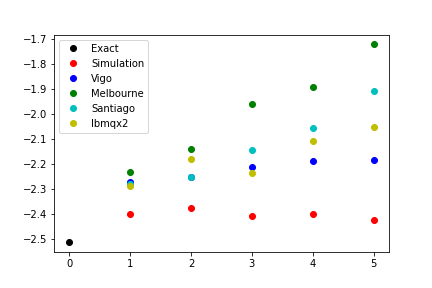

In [72]:
display(Image('zne without extrapolation.png'))

To use mitiq with just a few lines of code, we simply need to define a function which inputs a circuit and outputs the expectation value to mitigate. This function will:

Add measurement(s) to the circuit.

Run the circuit.

Convert from raw measurement statistics (or a different output format) to an expectation value.

We define this function in the following code block. Because we are using IBMQ backends, we first load our account.

## Running with Noise
We can see that the result of the VQE with a noiseless qasm simulator, we can try to add noise by running a simulation with the noise characteristics of a real quantum computer 

In [37]:
results_noise = [-2.511639972107E+00,
-2.458433722856E+00,
-2.165740952187E+00,
-2.219961298297E+00,
-2.274047099602E+00,
-2.084818570955E+00,
]

error_noise = []
for i in range(len(results_noise)):
    error_noise.append(abs(results_noise[i]-results_noise[0])*100/abs(results_noise[0]))

Text(0, 0.5, 'Error Percentage')

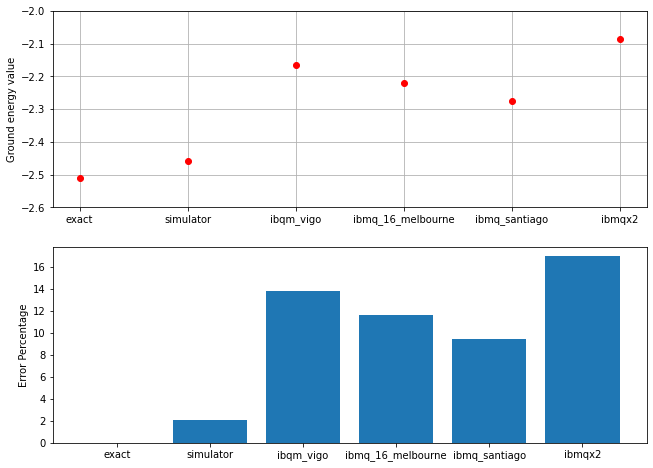

In [40]:
labels = ['exact','simulator','ibqm_vigo','ibmq_16_melbourne','ibmq_santiago','ibmqx2']

plt.figure(1)

plt.subplot(2,1,1)
plt.plot(labels,results_noise,'ro')
plt.gcf().subplots_adjust(right = 1.5,top = 1.5,bottom = 0)
plt.grid()
plt.ylim([-2.6,-2])
plt.ylabel('Ground energy value')


plt.subplot(2,1,2)
plt.bar(labels,error_noise)
plt.ylabel('Error Percentage')


## Using the mitiq platform 

Let's try to do some folding test with the trial circuit 

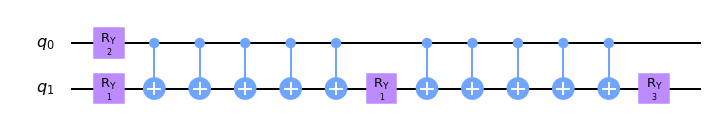

In [22]:
qc = State_Preparation([1,2,3])
from mitiq.zne.scaling.folding import fold_gates_at_random

#folded = fold_gates_from_left(qc, scale_factor=2)
#folded = fold_gates_from_right(qc, scale_factor=4,fidelities={"single": 1.0,"CNOT": 0.99})
folded = fold_gates_at_random(qc_IX, scale_factor=5,fidelities={"single": 1.0,"CNOT": 0.99})
#folded = fold_global(qc, scale_factor=3,fidelities={"single": 1.0,"CNOT": 0.99})

folded = scale_all_cnot(qc,3)

folded.draw('mpl')

In [19]:
import cirq
from mitiq.conversions import converter
from mitiq.zne.scaling.folding import _fold_gate_at_index_in_moment, deepcopy, _pop_measurements, _cirq_gates_to_string_keys, _append_measurements, squash_moments

@converter
def scale_all_cnot(circuit: cirq.Circuit, scale_factor: float) -> cirq.Circuit:
    # Insert custom folding method here
    
    folded = deepcopy(circuit)
    measurements = _pop_measurements(folded)
    
    moment_shift = 0
    for (moment_index, moment) in enumerate(circuit):
        for gate_index in range(len(moment)):
            op = circuit[moment_index].operations[gate_index]
            if op.gate == cirq.ops.CNOT:
                for _ in range(int(scale_factor)-1):
                    _fold_gate_at_index_in_moment(
                        folded, moment_index + moment_shift, gate_index
                    )
                    moment_shift += 2
    _append_measurements(folded, measurements)
    folded = squash_moments(folded)
    
    return folded

folded = scale_all_cnot(qc,1)


In order to use the mitiq tools we require to have a function that depends only on a quantum circuit. For this reason the expectation value hamiltonian functions we previously defined is not very useful, given that it creates the circuit from the theta parameters. So we redefine the function, with the only requirement of having to define the state preparation beforehand.  

In [33]:
from functools import partial
from mitiq.zne.inference import *

qc = State_Preparation([2.39581172, 5.94579978, 0.29905988],r=1)

def Expectation_Hamiltonian_Mitiq(qc,Hamiltonian = H,noise = False, r = 1,shots=8192,backend = 'qasm_simulator'):
    #Find the Pauli decomposition
    c = Decomposition_H(H)
    exp_key = c.copy() #copy the dictionary 
    

    H_exp = 0 #Expectation value initiation
    
    for keys in c.keys():
        if c[keys] == 0: #If contribution is zero then skip step
            continue
        
        #Expectation value for Pauli matrices
        qc_key = Circuit_Measurement(qc,keys)
        
        #Run for expectation value
        exp_key[keys] = Expectation_Measurement(qc_key,keys,shots = shots,backend = backend,noise = noise)
        H_exp += c[keys]*exp_key[keys]
    return H_exp


executor = partial(
    Expectation_Hamiltonian_Mitiq,
    shots=8192
)

linear_fac = LinearFactory([1,2,3,4,5,6])

mitigated = mitiq.execute_with_zne(qc,executor, factory = linear_fac,scale_noise=scale_all_cnot)
linear_fac.get_expectation_values()


array([-0.99634861, -1.00276807, -1.00805695, -0.98193931, -0.9911364 ,
       -0.98750552])

We now use the Mitiq package to get the desired results without needing to define the optimizer function or running for several points

In [58]:
# First get the optimal theta for each of the machines 

noise = [False,
         'ibmq_vigo',
         'ibmq_16_melbourne',
         'ibmq_santiago',
         'ibmqx2'
         ]

shots = 8192


Noise_Scaling_mitiq = [] 

#Obtain a solution with the standard circuit
for n in noise: 
    
    #Define the executor to work with this particular type of noise 
    executor = partial(
        Expectation_Hamiltonian_Mitiq,
        shots = shots,
        noise = n,
                                                                            )
    
    #Define factory (Statistical method)
    fac = LinearFactory([1,2,3,4,5,6])
    
    
    #List with results for specific noise
    Noise_extrapolation_mitiq = []
    
    #Obtain solutions for r = 1
    sol = Optimize(H,noise = n)
 

    #Extract values of theta and expectation value
    theta_optimal = sol.x
    

    #Prepare the circuit to be used by mitiq 
    qc = State_Preparation(theta_optimal)

    #Run mitiq optimizer
    #zne = mitiq.execute_with_zne(qc,executor, factory = fac,scale_noise=scale_all_cnot) #Executor with cnot gates
    zne = mitiq.execute_with_zne(qc,executor, factory = fac)
    
    #Save results for respective noise machine
    Noise_extrapolation_mitiq.extend(list(fac.get_expectation_values())) #then saves the calculated expectation values
    Noise_extrapolation_mitiq.insert(0,zne) #saves the zne result    

    Noise_Scaling_mitiq.append(Noise_extrapolation_mitiq) #add to the list of list with each noise



C:\Users\javie\anaconda3\envs\qiskit_env\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
C:\Users\javie\anaconda3\envs\qiskit_env\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
C:\Users\javie\anaconda3\envs\qiskit_env\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
C:\Users\javie\anaconda3\envs\qiskit_env\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
C:\Users\javie\anaconda3\envs\qiskit_env\lib\site-packages\scipy\optimize\_minimize.py:527: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


### Graph of results 

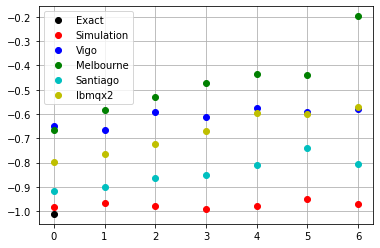

In [59]:
#Extract the results
zne_simulation_mitiq = Noise_Scaling_mitiq[0]
zne_vigo_mitiq = Noise_Scaling_mitiq[1]
zne_melbourne_mitiq = Noise_Scaling_mitiq[2]
zne_santiago_mitiq = Noise_Scaling_mitiq[3]
zne_ibmqx2_mitiq = Noise_Scaling_mitiq[4]

#Results to be stored in a .cvs file 
zne_noextrap  = (zne_simulation_mitiq,zne_vigo_mitiq,zne_melbourne_mitiq,zne_santiago_mitiq,zne_ibmqx2_mitiq)


#Graph results without extrapolation 
labels = [0,1,2,3,4,5,6]

plt.figure()
plt.plot(0,eigenH[0],'ko')
plt.plot(labels,zne_simulation_mitiq,'ro')
plt.plot(labels,zne_vigo_mitiq,'bo')
plt.plot(labels,zne_melbourne_mitiq,'go')
plt.plot(labels,zne_santiago_mitiq,'co')
plt.plot(labels,zne_ibmqx2_mitiq,'yo')
plt.gca().legend(('Exact','Simulation','Vigo','Melbourne','Santiago','Ibmqx2'))

_ =plt.savefig('ZNE_Linear_Mitiq_Random.png')
plt.grid()

np.savetxt("ZNE_Linear_Mitiq_Random.csv",zne_noextrap, delimiter=",")


In [57]:
eigenH[0]
print(eigenH[0],zne_simulation_mitiq)

-1.0116399721069198 [-1.012007190902425, -0.9997346950968863, -1.0158616101659086, -1.016414683790339, -0.9888321938651021, -1.0048262795341962, -0.9946217457103823]


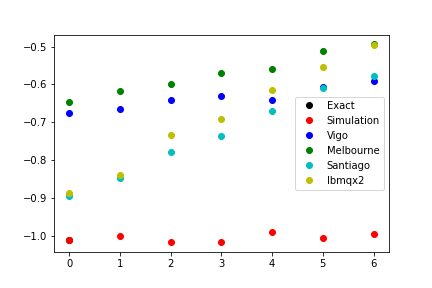

In [60]:
display(Image('ZNE_Linear_Mitiq_CNOT.png'))